# Deep Convolutional GAN으로 CIFAR-10 이미지 만들어보기 

- DCGAN 모델은 두개의  생성기와 판별기 네트워크를 사용한다.     
    
    - 생성기 :  가우시안 분포 노이즈를 통한 이미지를 입력받아  transposed convolution을 이용하여 Cifar-10 이미지와 비슷한 이미지를 출력한다.  
    
    - 판별기: 실제 Cifar 이미지와 생성기를 통해 받은 이미지를 구별한다.
    
- DCGAN 모델의 학습 방법 :
    - 생성기 :판별기에 가짜 이미지를 입력받았을때 나온 로스를 통해 학습을 한다.(가짜를 진짜로 판단하게 해야하기 때문에 판별기에서 진짜로 판단했을때와 가짜이미지를 넣었을때의 결과의 로스이다.)  
    - 판별기:  실제 이미지와 가짜이미지(생성기를 통해 만들어진)를 입력받고 구분을 하며 학습한다.
    이를 통하여 생성기가 진짜와 같은 이미지를 만들어낼수록, 판별기가 이미지를 잘 구분 할 수록 두 네트워크는 시너지를 가진다.

- 내가 생각하는 이상적인 학습방향
    - 처음엔 판별자가 구분을 잘 하다가 점점 생성자가 잘 만들기 시작하면서 두 네트워크의 로스가 0.5가 되는 방향으로 진행되는 것  

# STEP 1. 작업환경 구성하기
다음과 같이 작업환경을 구성합시다.


In [226]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

데이터셋을 가져와 봅시다!
Cifar-10 데이터는 우리가 인터넷에서 따로 다운로드할 필요 없이,tf.keras 안에 있는 datasets에 이미 들어가 있어서 꺼내기만 하면 됩니다.

꺼내서 load_data()로 데이터를 로딩해 볼 텐데, 특히 이번에는 분류 문제에서와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없습니다. 즉, 우리가 MNIST 데이터로 분류 문제를 풀었을 때 필요했던 y_train, y_test에 해당하는 데이터를 쓰지 않는 거죠. 그렇기 때문에 코드에서 _ (언더스코어)로 해당 데이터들은 무시하도록 하겠습니다.

In [227]:
cifar10 = tf.keras.datasets.cifar10

(train_x, label), (test_x, label2 ) = cifar10.load_data()
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
train_x.shape


max pixel: 255
min pixel: 0


(50000, 32, 32, 3)

In [228]:
print(label)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


- Cifar-10 데이터들은 32 32 3 shape를 가지고 50000개의 이미지가 있다.

In [229]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
#-1~1로 정규화
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
print("train_shpae : ",train_x.shape)

max pixel: 1.0
min pixel: -1.0
train_shpae :  (50000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


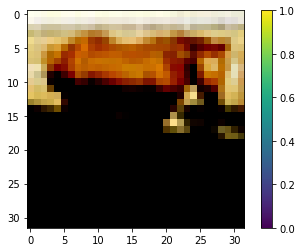

In [230]:
plt.imshow(train_x[2000].reshape(32, 32,3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

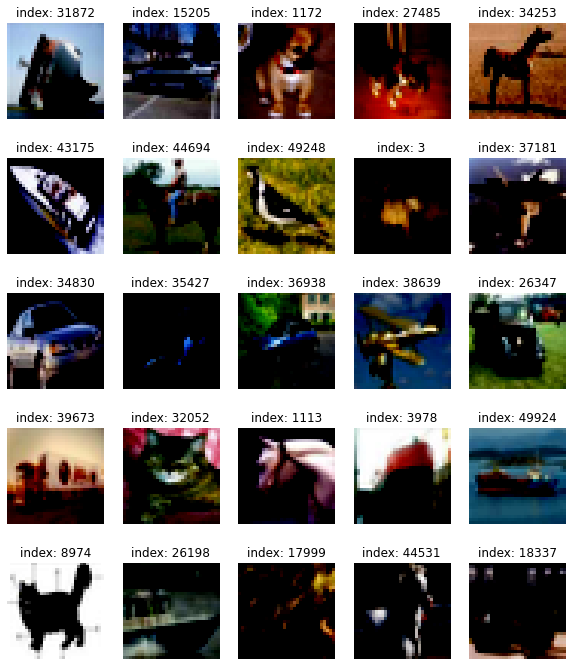

In [231]:
a = np.random.rand(5)
plt.figure(figsize=(10, 12))

for i in range(25):
    ran = np.random.randint(1, 50000)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[ran].reshape(32, 32,3), cmap='gray')
    plt.title(f'index: {ran}')
    plt.axis('off')
plt.show()

- 이미지 정규화 및 확인

plt.figure(figsize=(, ))는 이미지의 전체 프레임의 크기를 결정합니다.
여러 개의 이미지를 한 번에 띄우고 싶을 때에는 plt.subplot(row, col, index)의 형태로 볼 수 있습니다.
10개의 이미지를 2x5의 배열 형태로 보고 싶은 경우, plt.subplot(2, 5, index)로 작성

추가적으로 plt.title('title') 함수를 이용해서 이미지에 제목으로 라벨 값을 넣어줬고, plt.axis('off') 함수로 불필요한 축을 지워서 깔끔하게 나타냈습니다.

In [232]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정합니다. shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.

BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양입니다.
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다. 이러한 방식을 미니 배치 학습 이라고 합니다.

tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다. 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

# STEP 3. 모델 구현하기
## 1) 생성자 모델 구현하기
## 2) 판별자 모델 구현하기
## 3) 손실함수와 최적화 함수 구현하기
## 4) 훈련과정 상세 기능 구현하기

In [233]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
   

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [234]:
generator = make_generator_model()

generator.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_79 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_145 (LeakyReLU)  (None, 16384)             0         
_________________________________________________________________
reshape_22 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_79 (Conv2DT (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_80 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_146 (LeakyReLU)  (None, 8, 8, 128)       

#### 제너레이터 만들기
2D TP convolution 계산 :
new_rows = ((rows - 1) strides[0] + kernel_size[0] - 2 padding[0] +output_padding[0])

padding = "same"을 걸면 아주 간단하게 input size * stride = output size가 되도록 padding을 해줍니다.

결국 제너레이터 모델은 real 이미지와 같은 이미지 쉐이프가 만들어져야하기 때문에 stride를 통하여 잘 조정해주었습니다.
8 -> 16 -> 32


In [235]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

#### generator 인풋 만들기
- 제너레이터의 인풋은 가우시안 노이즈로 형성된 1,100 이미지
- 제너레이터를 통해 만들어진 이미지 형태가 cifar 이미지 shape와 같은 것을 볼 수 있다.

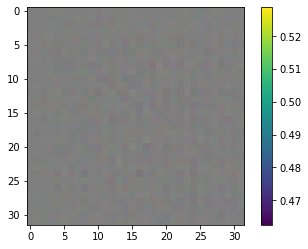

In [236]:
plt.imshow((generated_image[0]+ 1.0) / 2.0)
plt.colorbar()
plt.show()

In [237]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [238]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_148 (LeakyReLU)  (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_149 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 8192)            

#### 판별기 만들기

- 판별기는 이미지 특성을 추출하여 판단하여야 하기때문에 conv2d 층을 사용하고 과적합과 학습속도를 위해 dropout을 사용해준다.

- 판별기는 히든레이어의 출력이 leakyrelu면 좋고, 최종출력은 sigmode가 좋다라고 한다.

- 내가 생각하기엔 -1~1사이로 정규화된 이미지를 학습하기 때문에 leaky relu를 사용해서 음수를 안버리고 사용하고 최종출력은 가장 간단한 이진분류인 sigmode를 활용한것 같다.

In [239]:
decision = discriminator(generated_image, training=False)
print('{}'.format(decision))

[[0.00473155]]


discriminator의 결과값이다. 아까만든 노이즈를 넣고 나온 출력이 -0.002458이란것  진짜 이미지와 가짜 이미지를 구별 할 수 있다.

In [240]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용

- Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과
     - 생성기 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
     - 판별기 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것
결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요! 이러한 기준을 가지고 생성자, 판별자 각각에 대, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 

판별기 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. => 판별기가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있다. -> from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.



In [241]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [242]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### generator_loss
- generator_loss는 fake_output가 1에 가까워져야하기 때문에, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산   

#### discriminator_loss
- discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워져야하기 때문에, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교




fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)  
real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)


In [243]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### discriminator_accurac

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])  
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])  
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5

In [244]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- 옵티마이저와 학습률

In [245]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.  
샘플은 한 번에 16장을 생성하도록 하겠습니다.  
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.  
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [246]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

TensorFlow 2.0의 자동 미분 기능인 GradientTape

GradientTape은 자동 미분을 통해 동적으로 Gradient 값들을 확인해 볼 수 있다는 장점을 가지고 있습니다.

직접 print 해볼 수 있고, 또한 시각화 해 볼 수 있습니다.



train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력  
6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산  
8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신  
10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴 이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.  

In [247]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8')) # 역정규화
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

- 이미지 세이브 모델 , 노이즈(seed)들을 받고 model로 이미지를 생성해준것을 plt.savefig를 통해 저장 

In [248]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없겠습니다.   
GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다.  
train_step() 함수가 리턴하는 gen_loss, disc_loss, real_accuracy, fake_accuracy 이상 4가지 값을 history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들어 봅시다. 예를 들어 생성자의 loss의 history는 history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

In [249]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.

tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적입니다. 아주 오랜 시간 동안 학습을 시켰는데 네트워크가 끊긴다거나, 예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없을 테니까요..!

checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장합니다. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것이죠. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.

checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용하겠습니다.



In [250]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

- 학습의 총합
- train step을 통해 얻은 history들을 it%50 때마다 보여주고 저장한다. 

In [217]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [219]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_mnist_dcgan.gif

-rw-r--r-- 1 root root 2101197 Feb 15 15:00 /aiffel/aiffel/dcgan_newimage/cifar10/cifar_mnist_dcgan.gif


- Gif 만들기

GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 만들 수 있습니다.
imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식입니다.
아래 코드가 무사히 실행되면, fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인할 수 있을 겁니다!
클라우드에서는 확인을 위하여 cloud jupyrer를 열어서 ~/aiffel/dcgan_newimage/cifar10/ 폴더 경로에 cifar_mnist_dcgan.gif를 클릭하시면 생성자가 만들어내는 이미지의 품질이 점점 개선되어 가는 과정을 한눈에 볼 수 있습니다.



![](1.gif)

# 모델 개량해보기

-  drop out 비율 바꿔보기
- 모델 층 늘려보기
- 학습률 바꿔보기
- epochs 늘려보기

https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
https://seing.tistory.com/110
https://arxiv.org/abs/1511.06434



- make_generator_model_2 : batchnomalization 말고 dropout 썼다.
- make_discriminator_model_2 : dropout 비율을 0.5로 바꿔주엇다.
- make_generator_model_3 : 모델 층 추가
- make_discriminator_model_3 : 모델 층 추가
- make_generator_model_4 :make_discriminator_model_3에서 층 하나 더 추가
- make_discriminator_model_4 :  model.add(layers.LeakyReLU(alpha=0.2)) leakyrelu 알파값조정
- make_discriminator_model_5 : make_discriminator_model_4에서 dropout 0.5 -> 0.3


In [220]:
def make_generator_model_2():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.Dropout(0.5))
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Dropout(0.5))
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [221]:
def make_discriminator_model_2():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [222]:
def make_discriminator_model_3():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    # Second: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    # Third : Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model


In [223]:
def make_generator_model_3():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 512)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
   

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [224]:
def make_discriminator_model_4():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.5))
    # Third : Conv2D Layer
   
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model


In [225]:
def make_generator_model_4():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 1024)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # Fourth: Conv2DTranspose layer
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
   

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

- epochs 50을 돌려 싹(될만한)이 보이는 조합을 찾았다.

generator = make_generator_model(),discriminator = make_discriminator_model_3()
이 조합을 epochs 500을 돌려보기로 했다. 


In [130]:
generator = make_generator_model()
discriminator = make_discriminator_model_3()

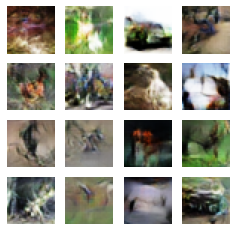

Epoch 347 | iter 1
Time for epoch 347 : 1 sec


KeyboardInterrupt: 

In [31]:
%%time
train(train_dataset, 500, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

![](./train_history_0345.png)
![](./cifar_mnist_dcgan_1.gif)
![](sample_epoch_0346_iter_101.png)
![](sample_epoch_0346_iter_151.png)
![](sample_epoch_0347_iter_001.png)
### 500을 돌리는 와중 더이상 fake accuracy가 안내려갔다. 
### 이미지또한 색만 바뀌는중 제너레이터가 과적합이 일어났다고 판단 후 중단
### Fake Accuracy가 0.8밑으로 떨어지진 않지만 만들어진  이미지는 그럴듯한 형상을 띄고있다.
### generator의 학습률을 0.0002로 높여 discriminator 보다 빠르게 학습해서 두 그래프의 정확도가 0.5로 가길바랬다.

In [132]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator = make_generator_model()
discriminator = make_discriminator_model_3()

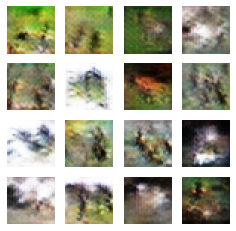

Epoch 108 | iter 1
Time for epoch 108 : 1 sec


KeyboardInterrupt: 

In [87]:
%%time
train(train_dataset, 500, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

![](./train_history_0106.png)
![](./cifar_mnist_dcgan_2.gif)
###  제너레이터의 학습률을 조금 올려줬지만  위의 경우처럼 RGB색만 바뀌지 이미지 벡터특성은 안바뀌는 현상이 나온다.
### 생성자가 문제인지 판별자가 문제인지 햇갈렸다.  
### 기본적으로 판별자는 오버피팅되어도 상관없다고 생각했다. 왜냐하면 어차피 생성자가 잘만들어주면 그 오버피팅은 풀릴거라고 판단 그래서 레이어가 조금더 깊은 제너레이터를 만들어서 조합했다. -> generaator_model4와 discriminator model3를 조합했다.

In [133]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator = make_generator_model_4()
discriminator = make_discriminator_model_3()


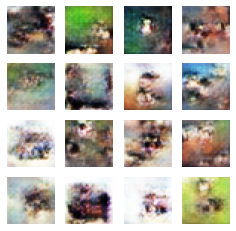

Time for training : 2859 sec


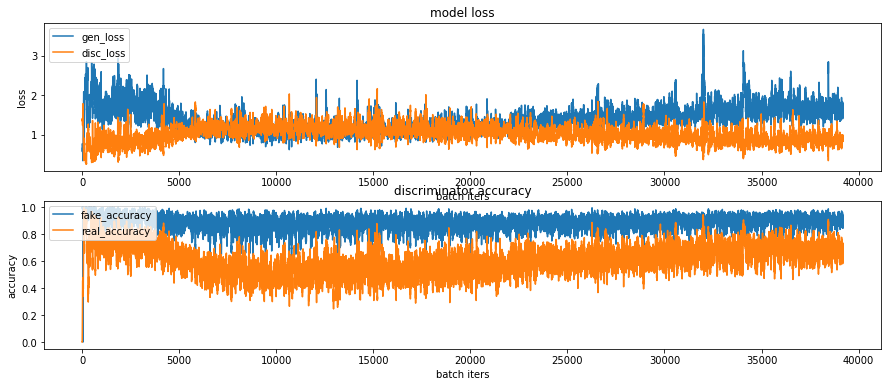

CPU times: user 49min 14s, sys: 5min 13s, total: 54min 27s
Wall time: 47min 41s


In [121]:
%%time
train(train_dataset, 200, save_every)

# 전 모델보다 fake 정확도가 떨어져 한번 이미지를 생성해봐서 확인해보았다.

# 결국 그래프를 보면 결국 이것도 초반 부 몇번만 fake accuracy가 많이 떨어지고 계속 고정된다.

# 판별자가 너무 학습을 잘해서 생기는 문제인가? 라는 생각이들어 최초 base모델을 판별자로 사용하고 생성자를 make_generator_model_4()로 사용

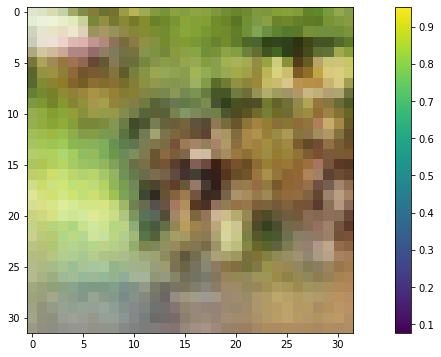

In [125]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow((generated_image[0]+ 1.0) / 2.0)
plt.colorbar()
plt.show()

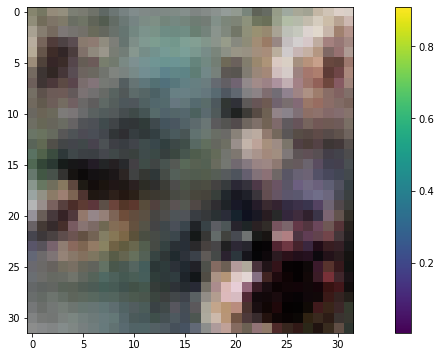

In [127]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow((generated_image[0]+ 1.0) / 2.0)
plt.colorbar()
plt.show()

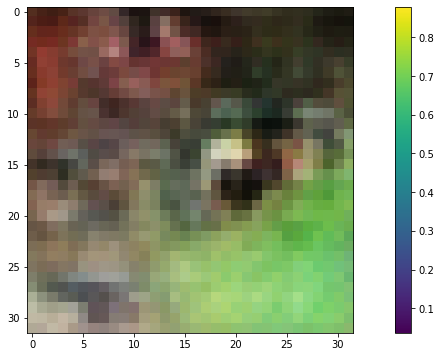

In [126]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow((generated_image[0]+ 1.0) / 2.0)
plt.colorbar()
plt.show()

In [251]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator = make_generator_model_4()
discriminator = make_discriminator_model()


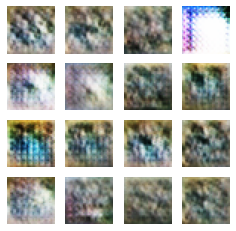

Time for training : 7726 sec


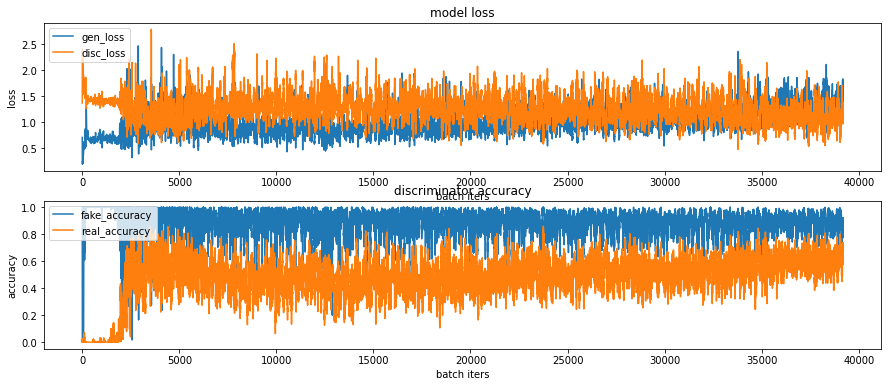

CPU times: user 2h 9min 50s, sys: 5min 15s, total: 2h 15min 5s
Wall time: 2h 8min 48s


In [252]:
%%time
train(train_dataset, 200, save_every)

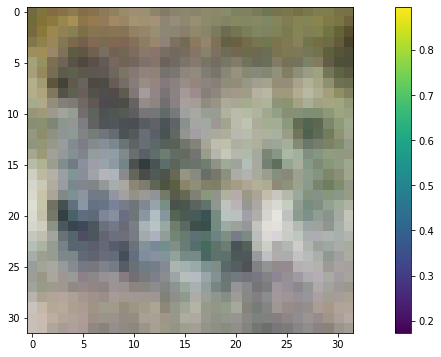

In [253]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape
plt.imshow((generated_image[0]+ 1.0) / 2.0)
plt.colorbar()
plt.show()

#### 원하는 그래프 모양이 나왔다.
#### 하지만 아직 제대로 된 이미지가 나오지 않았으니 학습을 더 해봐야겠지만 시간이 없었다.
#### 시너지는 나지만 오히려 학습시간은 오래걸렸다.

# 회고 

## 배우게 된점
#### gan모델 자체의 모델과 모델을 경쟁시켜 시너지를 내는 발상이 강화학습도 생각나고 재미있었다.  
#### gif를만드는 방법과, 훈련을 하며 결과를 훔쳐보는 방법을 배워 유용하였다.
#### 모델 개선에 대한 생각을 많이 할 수 있었다.

##  ※모델 개선에 대한 생각의 흐름 


#### 초기의 생각은 판별자가 더 깊고, 분류를 잘해야된다고 생각하였다. 
- 생성자는 판별자가 분류를 잘할 수록 loss가 커지면서 학습을 계속해 결국은 epochs이 커질수록 두 모델의 정확도는 0.5가 가는게 이상적으로 보였기 때문

####  판별자 위주로 깊게, drop out등을 조정, 생성자는 그대로  
- 깊고 파라메타가 많은 판별자 + base 생성자 의 결과는 Fake accuracy가 고정이 되었다. 이상적인 생각과 맞지 않다.
- 훈련 과정에서 생성자가 만들어낸 이미지를 보니 이미지의 모양(형태)는 고정 ,색( RGB)값만 바뀌는 현상이 나왔다. 
> RGB비율(채널당 비율)만바뀌지 그 어떤 특정파라매타 값이 고정이 되었다고 생각을 했고 fake accuracy를 낮추기 위해  생성자의 파라매타를 늘려야겠다라고 생각.

#### 생성자의 파라메타를 늘리고 더 깊게 하였다, 학습율도 생성자는 조금더 크게 잡았다. (0.0001 => 0.0002)
> 결과는 fake accuracy가 0.8로 낮아졌지만 고정되었다.  
생성자가 만든 이미지 자체는 자동차, 동물등 잘 나온 이미지도 있었다.

####  fake accuracy가 계속 고정되는 현상을  보아 판별자가 성능이 우수해서 처음 생각한 시너지가 안나온다고 판단
>판별자가 초기에 이미 cifar 이미지와 가짜이미지를 너무 구분을 잘하다보니 모델 두개가 서로 주고받고 티키타카를 안한다는 생각이 들었다.

##### 생성자만 파라메타를 늘리고 깊이를 늘린다음, 판별자는 lms에서 쓰인 모델을  사용해보자.
> 원하는 그래프 모양이 나왔다. 하지만 아직 제대로 된 이미지가 나오지 않았으니 학습을 더 해봐야겠지만 시간이 없었다.
시너지는 나지만 오히려 학습시간은 오래걸렸다. 만약 시간이 더 된다면 좋은 제너레이터가 만들어졌을것같다.


# 밑에 코드는 삽질의 결과들이다. 삭제하다가 갑자기 마음이 아파 남겨두었다.


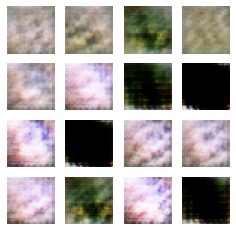

Time for training : 2555 sec


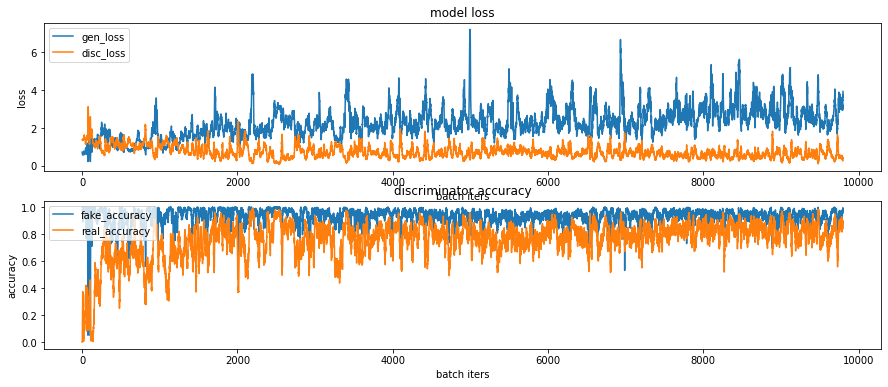

CPU times: user 42min 43s, sys: 1min 18s, total: 44min 1s
Wall time: 42min 36s


In [36]:
%%time
train(train_dataset, EPOCHS, save_every)

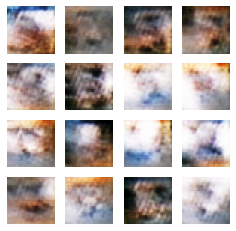

Time for training : 1437 sec


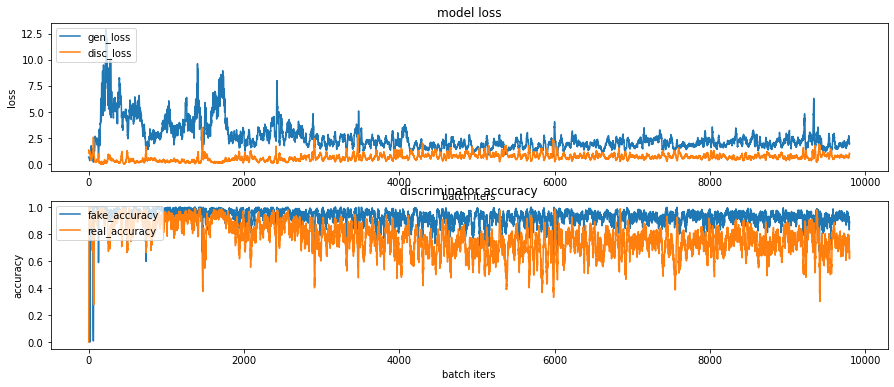

CPU times: user 24min 11s, sys: 1min 17s, total: 25min 28s
Wall time: 23min 58s


In [34]:
%%time
train(train_dataset, EPOCHS, save_every)

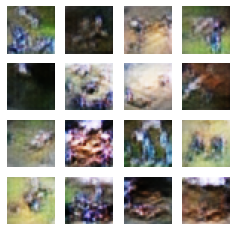

Time for training : 2811 sec


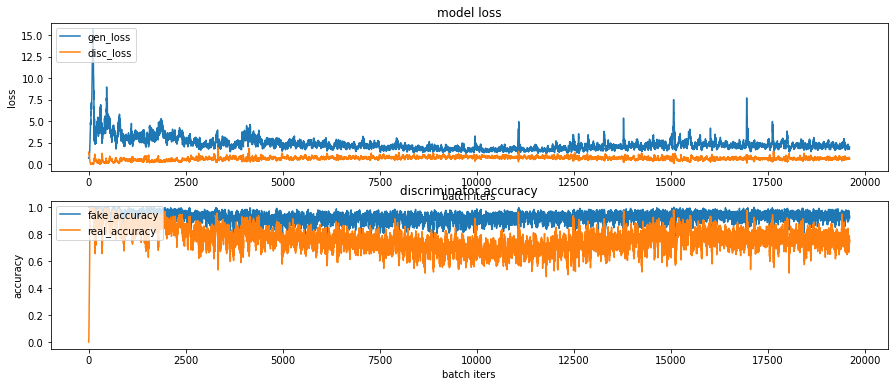

CPU times: user 47min 20s, sys: 2min 33s, total: 49min 54s
Wall time: 46min 52s


In [36]:

%%time
train(train_dataset, EPOCHS, save_every)

In [44]:
generator = make_generator_model()
generator.summary()

discriminator = make_discriminator_model_4()
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)        

In [74]:
generator = make_generator_model_2()
generator.summary()

discriminator = make_discriminator_model_4()
discriminator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
dropout_9 (Dropout)          (None, 16384)             0         
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 8, 8, 128)       

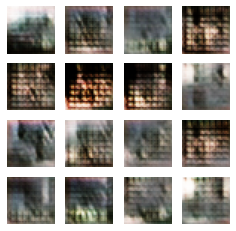

Time for training : 1700 sec


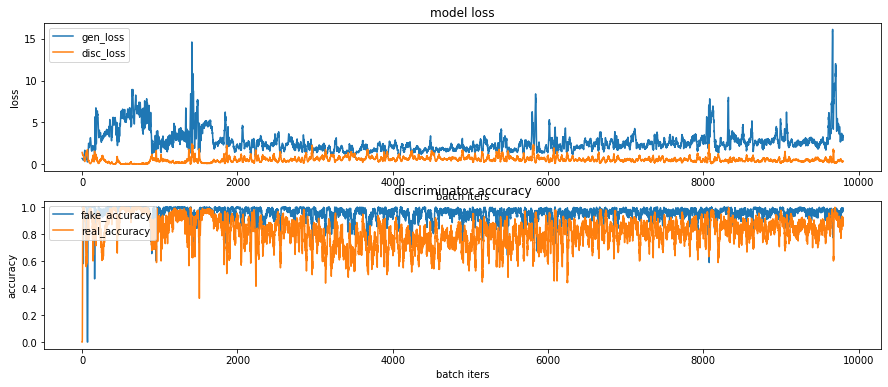

CPU times: user 28min 46s, sys: 1min 20s, total: 30min 6s
Wall time: 28min 21s


In [75]:
%%time
train(train_dataset, EPOCHS, save_every)

In [103]:
generator = make_generator_model_3()
generator.summary()

discriminator = make_discriminator_model_4()
discriminator.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32768)             3276800   
_________________________________________________________________
batch_normalization_21 (Batc (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 8, 8, 256)         1179648   
_________________________________________________________________
batch_normalization_22 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 8, 8, 256)       

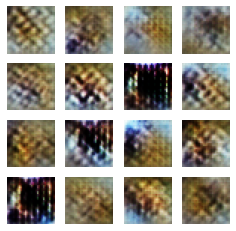

Epoch 26 | iter 51
Time for epoch 26 : 10 sec


KeyboardInterrupt: 

In [104]:
%%time
train(train_dataset, EPOCHS, save_every)

In [36]:
generator = make_generator_model_4()
generator.summary()

discriminator = make_discriminator_model_4()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 65536)             6553600   
_________________________________________________________________
batch_normalization_6 (Batch (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 65536)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 512)        

NameError: name 'make_discriminator_model_4' is not defined

In [72]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [43]:
def make_discriminator_model_5():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    # Third : Conv2D Layer
   
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model


In [44]:
generator = make_generator_model_3()
generator.summary()

discriminator = make_discriminator_model_5()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32768)             3276800   
_________________________________________________________________
batch_normalization_15 (Batc (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 8, 8, 256)         1179648   
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8, 8, 256)        

In [71]:
generator = make_generator_model()
generator.summary()

discriminator = make_discriminator_model_3()
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_12 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 8, 128)       

None
(1, 32, 32, 3)


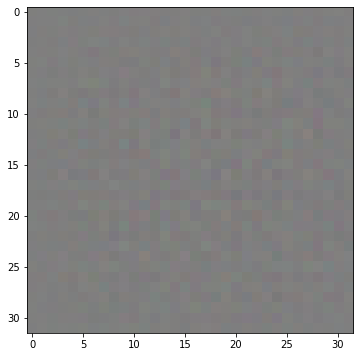

In [257]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  #

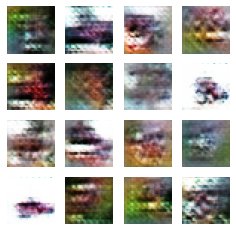

Time for training : 1597 sec


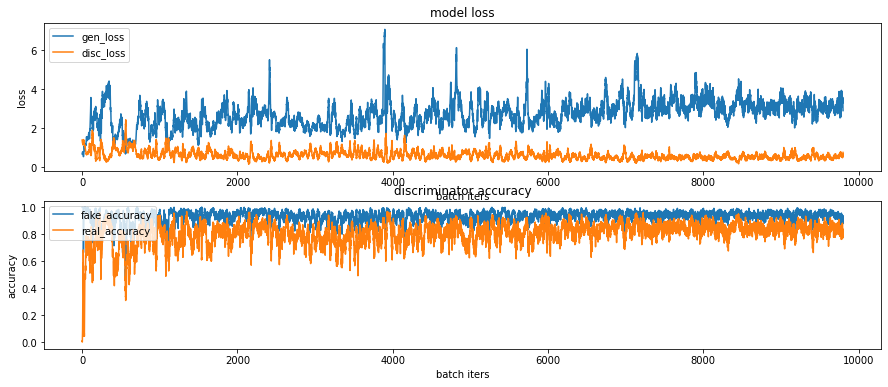

CPU times: user 26min 52s, sys: 1min 17s, total: 28min 10s
Wall time: 26min 37s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every)

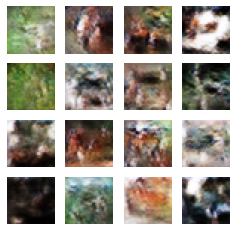

Time for training : 2903 sec


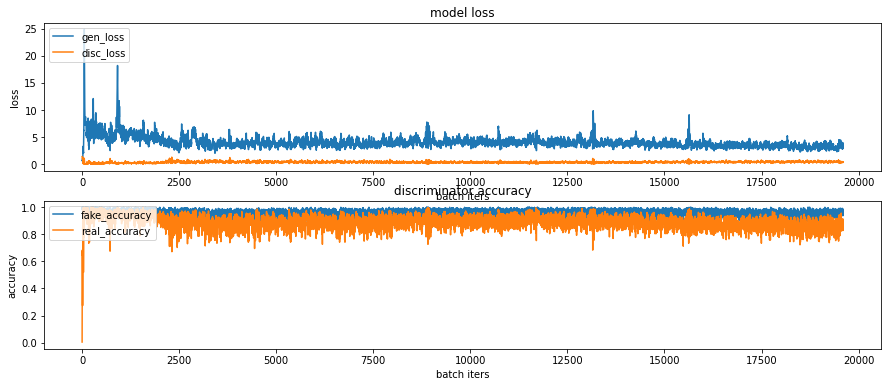

CPU times: user 48min 51s, sys: 2min 29s, total: 51min 21s
Wall time: 48min 25s


In [73]:
%%time
train(train_dataset, EPOCHS, save_every)

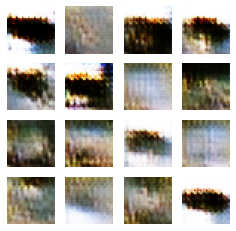

Epoch 51 | iter 151
Time for epoch 51 : 30 sec


KeyboardInterrupt: 

In [45]:
%%time
train(train_dataset, EPOCHS, save_every)

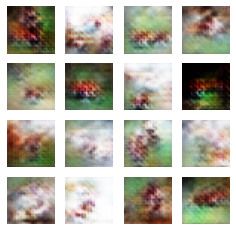

Time for training : 1647 sec


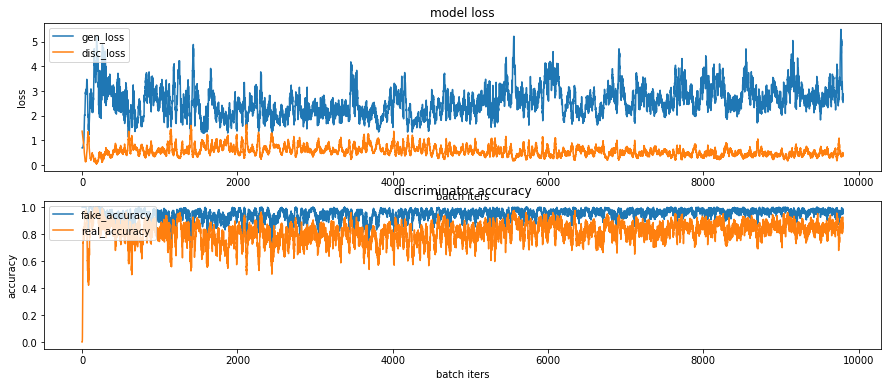

CPU times: user 27min 46s, sys: 1min 19s, total: 29min 5s
Wall time: 27min 27s


In [45]:
%%time
train(train_dataset, EPOCHS, save_every)

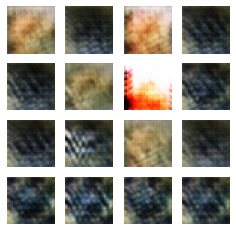

Time for training : 2856 sec


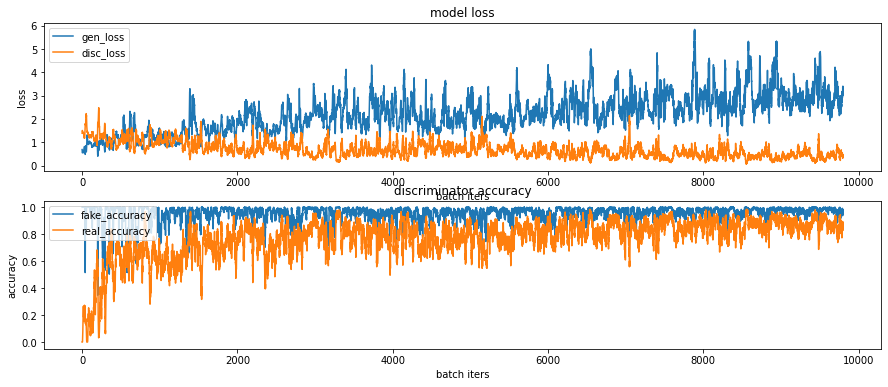

CPU times: user 47min 54s, sys: 1min 20s, total: 49min 15s
Wall time: 47min 37s


In [133]:
%%time
train(train_dataset, EPOCHS, save_every)